# ============================================================
# TASK 2  - EDA (BCGX Forage - PowerCo churn)
# ============================================================
    - Obiettivo: capire i dati, validare il target, verificare leakage, formulare ipotesi e definire una "spec" per FE+Modelling.

## -------------------------
## 1) Import + load data
## -------------------------

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

client_path = r"C:/Users/Utente/Desktop/BCG X (PER ME)/Task 2 Exploration Data Analysis (EDA)/client_data.csv"
price_path  = r"C:/Users/Utente/Desktop/BCG X (PER ME)/Task 2 Exploration Data Analysis (EDA)/price_data.csv"

client_data = pd.read_csv(client_path)
price_data  = pd.read_csv(price_path)

client_data.shape, price_data.shape

((14606, 26), (193002, 8))

## -------------------------
## 2) Parsing date + sanity checks
## -------------------------

In [2]:
# Parse date columns
date_cols_client = ["date_activ", "date_end", "date_modif_prod", "date_renewal"]
for c in date_cols_client:
    if c in client_data.columns:
        client_data[c] = pd.to_datetime(client_data[c], errors="coerce")

price_data["price_date"] = pd.to_datetime(price_data["price_date"], errors="coerce")

# Basic checks
print("client_data dtypes:\n", client_data.dtypes)
print("\nprice_data dtypes:\n", price_data.dtypes)

assert client_data["id"].isna().sum() == 0, "id missing in client_data"
assert price_data["id"].isna().sum() == 0, "id missing in price_data"
assert set(client_data["churn"].dropna().unique()).issubset({0,1}), "churn must be 0/1"

client_data dtypes:
 id                                        object
channel_sales                             object
cons_12m                                   int64
cons_gas_12m                               int64
cons_last_month                            int64
date_activ                        datetime64[ns]
date_end                          datetime64[ns]
date_modif_prod                   datetime64[ns]
date_renewal                      datetime64[ns]
forecast_cons_12m                        float64
forecast_cons_year                         int64
forecast_discount_energy                 float64
forecast_meter_rent_12m                  float64
forecast_price_energy_off_peak           float64
forecast_price_energy_peak               float64
forecast_price_pow_off_peak              float64
has_gas                                   object
imp_cons                                 float64
margin_gross_pow_ele                     float64
margin_net_pow_ele                       float64

## -------------------------
## 3) High-level overview
## -------------------------

In [3]:
print("Client rows:", len(client_data), "Unique ids:", client_data["id"].nunique())
print("Price rows :", len(price_data),  "Unique ids:", price_data["id"].nunique())

print("\nPrice coverage:", price_data["price_date"].min(), "->", price_data["price_date"].max())
print("Missingness (client):")
display((client_data.isna().mean().sort_values(ascending=False) * 100).head(15))

print("\nMissingness (price):")
display((price_data.isna().mean().sort_values(ascending=False) * 100).head(15))


Client rows: 14606 Unique ids: 14606
Price rows : 193002 Unique ids: 16096

Price coverage: 2015-01-01 00:00:00 -> 2015-12-01 00:00:00
Missingness (client):


id                                0.0
channel_sales                     0.0
cons_12m                          0.0
cons_gas_12m                      0.0
cons_last_month                   0.0
date_activ                        0.0
date_end                          0.0
date_modif_prod                   0.0
date_renewal                      0.0
forecast_cons_12m                 0.0
forecast_cons_year                0.0
forecast_discount_energy          0.0
forecast_meter_rent_12m           0.0
forecast_price_energy_off_peak    0.0
forecast_price_energy_peak        0.0
dtype: float64


Missingness (price):


id                    0.0
price_date            0.0
price_off_peak_var    0.0
price_peak_var        0.0
price_mid_peak_var    0.0
price_off_peak_fix    0.0
price_peak_fix        0.0
price_mid_peak_fix    0.0
dtype: float64

## -------------------------
## 4) Duplicates & key integrity
## -------------------------

In [4]:
dup_ids = client_data["id"].duplicated().sum()
print("Duplicate ids in client_data:", dup_ids)

# Price data duplicates per (id, price_date) are possible; check
dup_price = price_data.duplicated(subset=["id","price_date"]).sum()
print("Duplicate (id, price_date) in price_data:", dup_price)


Duplicate ids in client_data: 0
Duplicate (id, price_date) in price_data: 0


## -------------------------
## 5) Target distribution (churn rate)
## -------------------------

In [5]:
churn_rate = client_data["churn"].mean()
print("Churn rate:", churn_rate)

client_data["churn"].value_counts(dropna=False)


Churn rate: 0.09715185540188963


churn
0    13187
1     1419
Name: count, dtype: int64

“As-of” reasoning + reference date T

Il dataset price_data è mensile e copre solo il 2015. Assumo quindi come reference date operativa T = 2015-12-31 per costruire feature usando solo informazione <= T.
Nota: nel dataset non abbiamo una churn-date esplicita. Trattiamo il problema come snapshot:
features note fino a T -> churn nei 3 mesi successivi (come definito dal target).


## -------------------------
## 6) Leakage
## -------------------------

## Leakage gate #1: missingness per classe

In [6]:
# Questa è una delle cose più importanti in EDA: scovare "NaN che separano le classi"
X_tmp = client_data.drop(columns=["churn"], errors="ignore").copy()

miss_by_class = X_tmp.isna().groupby(client_data["churn"]).mean().T
miss_by_class["diff"] = (miss_by_class[1] - miss_by_class[0]).abs()
display(miss_by_class.sort_values("diff", ascending=False).head(20))


churn,0,1,diff
id,0.0,0.0,0.0
channel_sales,0.0,0.0,0.0
cons_12m,0.0,0.0,0.0
cons_gas_12m,0.0,0.0,0.0
cons_last_month,0.0,0.0,0.0
date_activ,0.0,0.0,0.0
date_end,0.0,0.0,0.0
date_modif_prod,0.0,0.0,0.0
date_renewal,0.0,0.0,0.0
forecast_cons_12m,0.0,0.0,0.0


## Leakage gate #2: feature “troppo predittive” (solo numeriche) 
NB: Questo non è modelling “vero”: è un controllo diagnostico.


In [7]:
from sklearn.metrics import roc_auc_score

num_cols = [c for c in client_data.columns if c not in ["id","churn"] and client_data[c].dtype != "object"]
scores = []

for c in num_cols:
    s = client_data[c]
    if s.isna().all(): 
        continue
    s_filled = s.fillna(s.median(numeric_only=True) if np.issubdtype(s.dtype, np.number) else 0)
    try:
        auc = roc_auc_score(client_data["churn"], s_filled)
        scores.append((c, auc))
    except Exception:
        pass

df_auc = pd.DataFrame(scores, columns=["feature","auc"])
df_auc["auc_abs"] = (df_auc["auc"] - 0.5).abs()
display(df_auc.sort_values("auc_abs", ascending=False).head(15))

,feature,auc,auc_abs
12,margin_net_pow_ele,0.599947,0.099947
11,margin_gross_pow_ele,0.599890,0.099890
15,num_years_antig,0.419395,0.080605
6,forecast_meter_rent_12m,0.540206,0.040206
16,pow_max,0.534908,0.034908
8,forecast_price_energy_peak,0.532859,0.032859
7,forecast_price_energy_off_peak,0.467760,0.032240
9,forecast_price_pow_off_peak,0.478302,0.021698
14,net_margin,0.519458,0.019458
1,cons_gas_12m,0.485407,0.014593


## -------------------------
## 7) Cardinalità categoriche e “rare categories” 
## -------------------------

In [8]:
cat_cols = [c for c in client_data.columns if client_data[c].dtype == "object"]
for c in cat_cols:
    n_unique = client_data[c].nunique(dropna=False)
    print(f"{c}: unique={n_unique}")
    display(client_data[c].value_counts(dropna=False).head(10))


id: unique=14606


id
24011ae4ebbe3035111d65fa7c15bc57    1
d29c2c54acc38ff3c0614d0a653813dd    1
764c75f661154dac3a6c254cd082ea7d    1
bba03439a292a1e166f80264c16191cb    1
149d57cf92fc41cf94415803a877cb4b    1
1aa498825382410b098937d65c4ec26d    1
7ab4bf4878d8f7661dfc20e9b8e18011    1
01495c955be7ec5e7f3203406785aae0    1
f53a254b1115634330c12c7fdbf7958a    1
10c1b2f97a2d2a6f10299dc213d1a370    1
Name: count, dtype: int64

channel_sales: unique=8


channel_sales
foosdfpfkusacimwkcsosbicdxkicaua    6754
MISSING                             3725
lmkebamcaaclubfxadlmueccxoimlema    1843
usilxuppasemubllopkaafesmlibmsdf    1375
ewpakwlliwisiwduibdlfmalxowmwpci     893
sddiedcslfslkckwlfkdpoeeailfpeds      11
epumfxlbckeskwekxbiuasklxalciiuu       3
fixdbufsefwooaasfcxdxadsiekoceaa       2
Name: count, dtype: int64

has_gas: unique=2


has_gas
f    11955
t     2651
Name: count, dtype: int64

origin_up: unique=6


origin_up
lxidpiddsbxsbosboudacockeimpuepw    7097
kamkkxfxxuwbdslkwifmmcsiusiuosws    4294
ldkssxwpmemidmecebumciepifcamkci    3148
MISSING                               64
usapbepcfoloekilkwsdiboslwaxobdp       2
ewxeelcelemmiwuafmddpobolfuxioce       1
Name: count, dtype: int64

## -------------------------
## 8) Distribuzioni numeriche principali
## ------------------------- 

In [9]:
num_candidates = ["cons_12m","cons_gas_12m","cons_last_month","imp_cons",
                  "net_margin","margin_gross_pow_ele","margin_net_pow_ele",
                  "pow_max","nb_prod_act","num_years_antig"]
num_candidates = [c for c in num_candidates if c in client_data.columns]

client_data[num_candidates].describe().T

,count,mean,std,min,25%,50%,75%,max
cons_12m,14606.0,159220.286252,573465.264198,0.0,5674.7500,14115.500,40763.7500,6207104.00
cons_gas_12m,14606.0,28092.375325,162973.059057,0.0,0.0000,0.000,0.0000,4154590.00
cons_last_month,14606.0,16090.269752,64364.196422,0.0,0.0000,792.500,3383.0000,771203.00
imp_cons,14606.0,152.786896,341.369366,0.0,0.0000,37.395,193.9800,15042.79
net_margin,14606.0,189.264522,311.798130,0.0,50.7125,112.530,243.0975,24570.65
margin_gross_pow_ele,14606.0,24.565121,20.231172,0.0,14.2800,21.640,29.8800,374.64
margin_net_pow_ele,14606.0,24.562517,20.230280,0.0,14.2800,21.640,29.8800,374.64
pow_max,14606.0,18.135136,13.534743,3.3,12.5000,13.856,19.1725,320.00
nb_prod_act,14606.0,1.292346,0.709774,1.0,1.0000,1.000,1.0000,32.00
num_years_antig,14606.0,4.997809,1.611749,1.0,4.0000,5.000,6.0000,13.00


## -------------------------
## 9) Skew/outlier diagnosis
## ------------------------- 

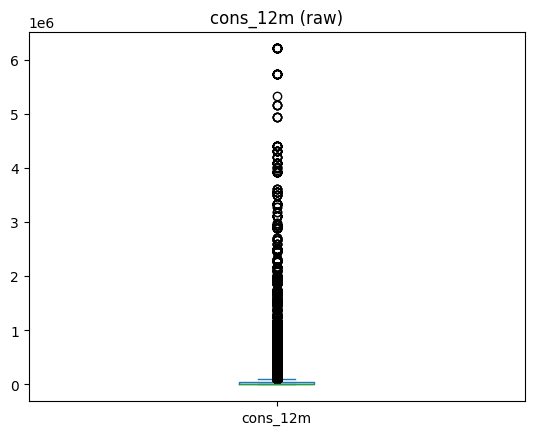

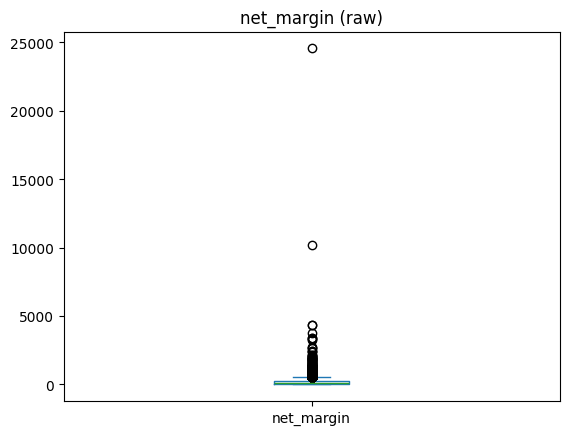

In [10]:
# Boxplot "grezzo" per capire skew/outlier
plt.figure()
client_data["cons_12m"].plot(kind="box")
plt.title("cons_12m (raw)")
plt.show()

plt.figure()
client_data["net_margin"].plot(kind="box")
plt.title("net_margin (raw)")
plt.show()

##### Nota EDA: probabilmente servirà log1p su consumi e margini (decisione per FE)

## -------------------------
## 10) Churn vs segmenti categorici 
## ------------------------- 

In [11]:
def churn_rate_by(col):
    tmp = client_data.groupby(col)["churn"].mean().sort_values(ascending=False)
    cnt = client_data[col].value_counts()
    out = pd.DataFrame({"count": cnt, "churn_rate": tmp})
    return out.sort_values("count", ascending=False)

for col in ["channel_sales","origin_up","has_gas","activity_new"]:
    if col in client_data.columns:
        print("\n", col)
        display(churn_rate_by(col).head(15))



 channel_sales


,count,churn_rate
channel_sales,,
foosdfpfkusacimwkcsosbicdxkicaua,6754,0.121410
MISSING,3725,0.075973
lmkebamcaaclubfxadlmueccxoimlema,1843,0.055887
usilxuppasemubllopkaafesmlibmsdf,1375,0.100364
ewpakwlliwisiwduibdlfmalxowmwpci,893,0.083987
sddiedcslfslkckwlfkdpoeeailfpeds,11,0.000000
epumfxlbckeskwekxbiuasklxalciiuu,3,0.000000
fixdbufsefwooaasfcxdxadsiekoceaa,2,0.000000



 origin_up


,count,churn_rate
origin_up,,
lxidpiddsbxsbosboudacockeimpuepw,7097,0.125828
kamkkxfxxuwbdslkwifmmcsiusiuosws,4294,0.060084
ldkssxwpmemidmecebumciepifcamkci,3148,0.083863
MISSING,64,0.062500
usapbepcfoloekilkwsdiboslwaxobdp,2,0.000000
ewxeelcelemmiwuafmddpobolfuxioce,1,0.000000



 has_gas


,count,churn_rate
has_gas,,
f,11955,0.100544
t,2651,0.081856


## -------------------------
## 11) Churn vs numeriche (distribuzioni semplici) 
## ------------------------- 

In [12]:
def compare_numeric(col):
    a = client_data.loc[client_data["churn"]==0, col].dropna()
    b = client_data.loc[client_data["churn"]==1, col].dropna()
    return {
        "col": col,
        "mean_no_churn": float(a.mean()) if len(a) else np.nan,
        "mean_churn": float(b.mean()) if len(b) else np.nan,
        "median_no_churn": float(a.median()) if len(a) else np.nan,
        "median_churn": float(b.median()) if len(b) else np.nan,
    }

rows = [compare_numeric(c) for c in num_candidates if c in client_data.columns]
display(pd.DataFrame(rows))

,col,mean_no_churn,mean_churn,median_no_churn,median_churn
0,cons_12m,167867.266550,78862.478506,14075.000,14529.000
1,cons_gas_12m,30121.497308,9235.411557,0.000,0.000
2,cons_last_month,17046.352089,7205.239605,800.000,740.000
3,imp_cons,152.964184,151.139331,36.670,41.400
4,net_margin,185.057407,228.361938,111.860,121.860
5,margin_gross_pow_ele,23.929863,30.468682,21.480,26.040
6,margin_net_pow_ele,23.926979,30.468682,21.480,26.040
7,pow_max,18.000339,19.387827,13.856,13.856
8,nb_prod_act,1.295822,1.260042,1.000,1.000
9,num_years_antig,5.037006,4.633545,5.000,4.000


## -------------------------
## 12) Price (aggregazioni TEMPORANEE)
## ------------------------- 

##### Qui facciamo una prima verifica “vale la pena investire sul prezzo?” ma senza costruire pipeline.

In [13]:
# Aggrego prezzi a livello cliente solo per EDA (non salvo in client_data)
price_vars = [
    "price_off_peak_var","price_peak_var","price_mid_peak_var",
    "price_off_peak_fix","price_peak_fix","price_mid_peak_fix"
]
p = price_data.dropna(subset=["price_date"]).copy()
p = p[p["price_date"] <= pd.Timestamp("2015-12-31")]

price_agg = p.groupby("id")[price_vars].mean().add_suffix("_mean2015").reset_index()
tmp = client_data[["id","churn"]].merge(price_agg, on="id", how="left")

# confronto medie tra churn/no-churn
rows = []
for c in [col for col in tmp.columns if col.endswith("_mean2015")]:
    rows.append({
        "feature": c,
        "mean_no_churn": tmp.loc[tmp["churn"]==0, c].mean(),
        "mean_churn": tmp.loc[tmp["churn"]==1, c].mean(),
        "diff(churn-no)": tmp.loc[tmp["churn"]==1, c].mean() - tmp.loc[tmp["churn"]==0, c].mean(),
    })

display(pd.DataFrame(rows).sort_values("diff(churn-no)", ascending=False))


,feature,mean_no_churn,mean_churn,diff(churn-no)
4,price_peak_fix_mean2015,9.274093,11.196663,1.922571
5,price_mid_peak_fix_mean2015,5.983379,7.159896,1.176517
3,price_off_peak_fix_mean2015,42.903812,43.161941,0.258129
2,price_mid_peak_var_mean2015,0.027729,0.033355,0.005626
1,price_peak_var_mean2015,0.051579,0.056562,0.004983
0,price_off_peak_var_mean2015,0.142375,0.141887,-0.000488


## -------------------------
## 13) Decisioni EDA + “Spec” per il notebook FE+Model
## ------------------------- 

In [ ]:
spec = {
    "T": "2015-12-31",
    "raw_date_cols": ["date_activ","date_end","date_modif_prod","date_renewal"],
    "leak_cols": ["dev_consum_no_churn","dev_consum_with_log"],
    "use_forecast": False,         # lo testeremo dopo con ablation
    "candidate_log_cols": ["cons_12m","cons_gas_12m","cons_last_month","imp_cons","net_margin","margin_gross_pow_ele","margin_net_pow_ele"],
    "metrics": ["PR-AUC","precision@10%","recall@10%"],
    "notes": [
        "Snapshot classification as-of T",
        "Leakage gate passed (no NaN separanti nel raw; attenzione a feature create in EDA)",
        "Prezzi puri: da testare con ablation; provare bill pressure (prezzo*volume)",
    ]
}

spec

{'T': '2015-12-31',
 'raw_date_cols': ['date_activ',
  'date_end',
  'date_modif_prod',
  'date_renewal'],
 'leak_cols': ['dev_consum_no_churn', 'dev_consum_with_log'],
 'use_forecast': False,
 'candidate_log_cols': ['cons_12m',
  'cons_gas_12m',
  'cons_last_month',
  'imp_cons',
  'net_margin',
  'margin_gross_pow_ele',
  'margin_net_pow_ele'],
 'metrics': ['PR-AUC', 'precision@10%', 'recall@10%'],
 'notes': ['Snapshot classification as-of T',
  'Leakage gate passed (no NaN separanti nel raw; attenzione a feature create in EDA)',
  'Prezzi puri: da testare con ablation; provare bill pressure (prezzo*volume)']}